In [309]:
# stress test for bank loans portfolio

In [310]:
#import libraries
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 

In [311]:
"""
importation du ptf de crédit

Risklevel : classe le risque global entre 1 et 3
Year On Book (YOB): l'âge du prêt, combien de temps s'est écoulé depuis que le prêt a été émis ou enregistré.
Loss Given Default (LGD) : fraction de l'exposition au défaut qu'un prêteur perd effectivement lorsqu'un emprunteur fait défaut sur un prêt, pertes potentilles en cas de défaut
Exposure At Default (EAD) : le montant que la banque est exposée au risque de défaut de l'emprunteur au moment du défaut. C'est l'encours du prêt ou la valeur de l'exposition au moment où l'emprunteur fait défaut.
"""

ptf = pd.read_excel("OutstandingLoans.xlsx")

In [312]:
# importation de notre historique de prêt 
# 1 = défaut de l'emprunteur au cours de la vie du prêt 
# 0 = pas de défaut de l'emprunteur au cours de la vie du prêt 

loanhistory = pd.read_excel("OldLoans.xlsx")

In [313]:
#importation de variables explicatives pour le modèle 
#Dow Jones return and GDP
Fedhistory = pd.read_csv("Simplified_FedHistory.csv")

In [314]:
# combiner les 2 datasets
combined = pd.merge(loanhistory, Fedhistory, on = "Year")

In [315]:
# création du modèle 
"""
on utilise ici un modèle de régression logistique. Ce genre de régression est utilisée pour modéliser les probabilités qu'un événement binaire se produise

Variable dépendante = défaut de paiement
Variable indépendante = YOB, DWJ_return, GDP, RiskLevel
Une distribution binomiale est choisie, appropriée lorsque la variable dépendante est binaire
"""
model = smf.glm(formula = "Default ~ RiskLevel + YOB + GDP + DJX_Return",
                data = combined,
                family = sm.families.Binomial())

In [316]:
# fit du modèle, ajustement du modèle sur les données, obligatoire
result = model.fit()

In [317]:
# estimation des probabilités de défaut, pour avoir les résultats des probabilités que ce soit un défaut
predictions = result.predict()

In [318]:
# calcul du taux de défaut historique selon l'ancienneté du prêt
defaut = combined.groupby('YOB').apply(lambda x : x['Default'].value_counts()).reset_index()
defaut['tete'] = (tete[1] / (tete[1]+tete[0]))*100
defaut = tete['tete'].tolist()
# defaut contient le taux de défaut en fonction des valeurs de YOB d'après les données historiques

In [319]:
# dataframe qui contient les YOB et les probabilités du modele predictif
model = pd.DataFrame({"YOB":np.array(combined["YOB"]), "est_defaut":predictions})

In [320]:
liste = model.groupby('YOB')['est_defaut'].apply(lambda x:(x.mean()*100))
liste = liste.tolist()

In [321]:
# scenario macroeconomique choisis
adversescenario = pd.read_csv("Simplified_Adverse.csv")

In [322]:
adversescenario

,Year,DJX_Return,GDP
0,2018,-24.626893,-2.129263
1,2019,2.358807,0.793390
2,2020,18.992974,3.074821


In [333]:
#choix du scenario 1

adverseptf = ptf.assign(Year=adversescenario.iloc[0,0],
                        DJX_Return = adversescenario.iloc[0,1],
                        GDP = adversescenario.iloc[0, 2])

,RiskLevel,YOB,LGD,EAD,Year,DJX_Return,GDP
0,1,1,0.25,21.627095,2018,-24.626893,-2.129263
1,1,2,0.25,3.259451,2018,-24.626893,-2.129263
2,1,3,0.25,20.390560,2018,-24.626893,-2.129263
3,1,4,0.25,3.753431,2018,-24.626893,-2.129263
4,1,5,0.25,5.719347,2018,-24.626893,-2.129263
...,...,...,...,...,...,...,...
95,2,1,0.35,89.606570,2018,-24.626893,-2.129263
96,2,2,0.35,7.515719,2018,-24.626893,-2.129263
97,2,3,0.35,35.214424,2018,-24.626893,-2.129263
98,2,4,0.35,6.476053,2018,-24.626893,-2.129263


In [324]:
# prediction des probabilités de défaut selon le scenario adverse
PD = result.predict(adverseptf)
#donne les proba de défaut sous les nouvelles conditions de marché

In [332]:
predPD = pd.DataFrame({"YOB": np.array(ptf["YOB"]), "PD": PD})

array([1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6,
       7, 8, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7,
       1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 7, 1,
       2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1,
       2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5])

In [326]:
# Calcule les probabilités de défaut prévues sous des conditions économiques défavorables pour chaque ancienneté du prêt.

predPD.groupby('YOB')['PD'].apply(lambda x:x.mean()*100).tolist()

[3.982521497721069,
 2.943495213881659,
 2.168485311155408,
 1.5936521270945518,
 1.1690837388095832,
 0.8584299541098007,
 0.6319821591949193,
 0.4426551084518642]

In [327]:
ExpectedLoss = sum(adverseptf["EAD"]*adverseptf["LGD"]*PD)

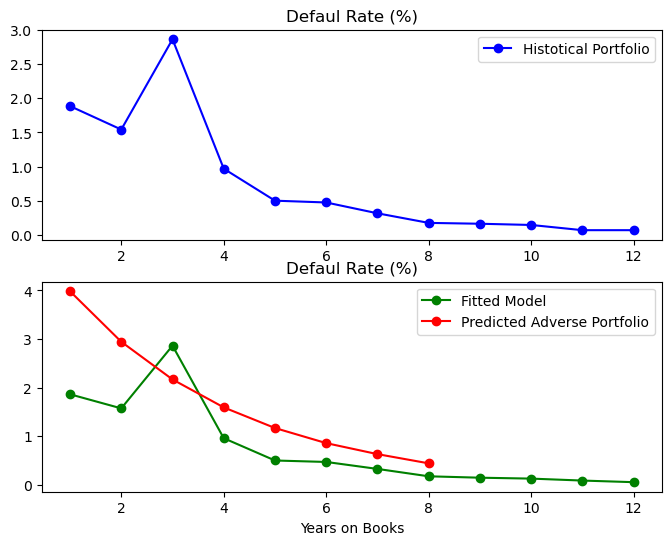

In [335]:
# Visualization with matplotlib.
plt.figure(figsize=(8, 6)) 
plt.subplot(2, 1, 1)
plt.plot(combined["YOB"].unique(), defaut, "o-", color = "blue", label = "Histotical Portfolio")
plt.title("Defaul Rate (%)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(model["YOB"].unique(), liste, "o-", color = "green", label = "Fitted Model")
plt.xlabel("Years on Books")
plt.legend()

plt.plot(predPD["YOB"].unique(), predDefault, "o-", color = "red", label = "Predicted Adverse Portfolio")
plt.title("Defaul Rate (%)")
plt.xlabel("Years on Books")
plt.legend()

plt.show()

Le graphique bleu montre le taux de défaut historique du portefeuille (Historical Portfolio) en fonction de l'ancienneté des prêts (Years on Books, YOB).

Initialement, il y a un taux de défaut relativement élevé pour les prêts ayant 1 à 2 ans d'ancienneté. Une augmentation notable du taux de défaut est observée à 3 ans. Après cette pointe, le taux de défaut diminue progressivement à mesure que l'ancienneté des prêts augmente. Les prêts ayant plus de 5 ans d'ancienneté montrent un taux de défaut beaucoup plus bas, se stabilisant presque à 0 après environ 10 ans.

Le graphique (vert et rouge) compare les taux de défaut estimés par le modèle ajusté (Fitted Model) et les taux de défaut prédits sous des conditions économiques défavorables (Predicted Adverse Portfolio).

Observation :

Les taux de défaut estimés par le modèle ajusté (en vert) montrent une tendance générale similaire au graphique historique, avec quelques fluctuations mais une diminution progressive du taux de défaut à mesure que les prêts vieillissent. Les taux de défaut prévus sous des conditions défavorables (en rouge) sont systématiquement plus élevés que ceux estimés par le modèle ajusté, ce qui est attendu étant donné que le scénario défavorable implique des conditions économiques plus strictes. On observe que pour les prêts plus récents (1-3 ans d'ancienneté), le taux de défaut est significativement plus élevé dans le scénario défavorable, ce qui suggère une sensibilité accrue aux conditions économiques adverses.

Conclusions : Les taux de défaut historiques montrent des variations notables avec une pointe aux alentours de 3 ans et une diminution progressive par la suite. Cela pourrait indiquer des périodes critiques pour les prêts où les risques de défaut sont plus élevés.

Le modèle ajusté suit assez bien les tendances historiques, ce qui valide sa précision pour les données passées. Le scénario défavorable montre que les taux de défaut augmenteraient sous des conditions économiques adverses, particulièrement pour les prêts plus jeunes. Cela met en évidence l'importance de surveiller et de gérer activement les risques de défaut, en particulier dans des environnements économiques instables.

Pourquoi modèle donne un taux de défaut supérieur pour YOB=3 que le scénario dévaforable :

Il se pourrait qu'il y ait eu des événements économiques ou financiers spécifiques il y a trois ans qui ont conduit à une augmentation exceptionnelle des défauts pour les prêts ayant atteint cette durée. Cela pourrait être une crise économique, une récession, des changements réglementaires, ou des conditions spécifiques du marché qui ont particulièrement affecté les prêts à ce stade

Les données historiques utilisées pour ajuster le modèle peuvent contenir des anomalies ou des biais qui ne sont pas présents dans les données du scénario défavorable. Par exemple, un grand nombre de défauts à trois ans dans les données historiques pourrait influencer fortement le modèle ajusté.

Le scénario défavorable que vous avez utilisé pour prédire les taux de défaut pourrait ne pas être assez sévère ou ne pas refléter précisément les conditions qui ont conduit à des défauts historiques à trois ans. Les hypothèses de ce scénario (DJX_Return et GDP) peuvent différer de la réalité historique ayant conduit à des défauts plus élevés.